In [3]:
cd /mnt/sda/otani/Experiments/moment_retrieval

/mnt/sda/otani/Experiments/moment_retrieval


In [5]:
%matplotlib inline
import matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from src.toolbox.utils import _nms, sentence2token
from src.toolbox.eval import evaluate, location_error, accumulate_metrics, categorize_results, summarize_results_per_class
from src.toolbox.utils import _nms
from src.toolbox.visualization import plot_performance_per_class, plot_performance_per_duration
from src.toolbox.data_converters import ActivityNetCap2Instances, CharadesSTA2Instances
from src.toolbox.baseline import SegmentGeneratorKDE, predict
import seaborn as sns
sns.set()
import json
import pickle as pkl

# Comaprison on Charade-STA

In [7]:
test_data = CharadesSTA2Instances(pd.read_csv('data/processed/test.csv'))

Uniform: 10.77
R@1 IoU>0.3 0.52
R@1 IoU>0.5 0.38
R@1 IoU>0.7 0.19
R@5 IoU>0.3 0.89
R@5 IoU>0.5 0.78
R@5 IoU>0.7 0.49
R@10 IoU>0.3 0.89
R@10 IoU>0.5 0.78
R@10 IoU>0.7 0.49
(0.0, 54.663000000000004)


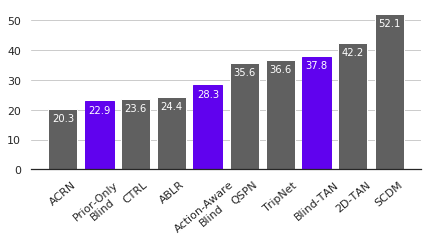

In [8]:
def get_charade_blindTAN_score():
    predictions = pkl.load(open("/home/otani_mayu/3TDisk/Experiments/2D-TAN/results/Charades/BlindTAN_None_test.pkl", "rb"))
    preds = []
    for p in predictions:
        query = (p[0][0], p[0][1]+".") # 2D-TAN remove '.' in description. Add to recover original input description.
        seg = p[1]
        keep = _nms(np.asarray(seg), np.arange(len(seg))[::-1], thresh=0.5, top_k=5)
        seg = [seg[i] for i in keep]
        preds.append((query, seg, np.arange(len(seg))[::-1].tolist()))
    results = evaluate(test_data, preds)
    summary = accumulate_metrics(results)
    return summary

def get_random_sampling_from_uniform():
    metric = json.load(open('reports/outputs/performance/charade-sta/random_from_uniform.json'))
    return np.mean(metric["R@1 IoU>0.5"])*100

print(f"Uniform: {get_random_sampling_from_uniform():.2f}")
leaderboard = {}
leaderboard["Prior-Only\nBlind"] = 22.88
leaderboard["Action-Aware\nBlind"] = 28.28
leaderboard["Blind-TAN"] = get_charade_blindTAN_score()["R@1 IoU>0.5"] * 100
# leaderboard.update({
#     "CTRL'17": 23.63,
#     "ACRN'18": 20.26,
#     "QSPN'19": 35.60,
#     "ABLR'19": 24.36,
#     "TripNet'19": 36.61,
#     "2D-TAN'20": 42.23,
# #     "2D-TAN\n(random)": 36.69,
# #     "2D-TAN\n(shuffle)": 38.31,
# #     "SCDM\n(shuffle)": 24.23,
#     "SCDM'19": 52.06, # https://arxiv.org/pdf/1910.14303.pdf
# })

leaderboard.update({
    "CTRL": 23.63,
    "ACRN": 20.26,
    "QSPN": 35.60,
    "ABLR": 24.36,
    "TripNet": 36.61,
    "2D-TAN": 42.23,
    "SCDM": 52.06, # https://arxiv.org/pdf/1910.14303.pdf
})

labels = list(leaderboard.keys())
scores = list(leaderboard.values())
sorted_idx = np.argsort(scores)
scores = [scores[i] for i in sorted_idx]
labels = [labels[i] for i in sorted_idx]
n = len(sorted_idx)

sns.set_style("white")
plt.figure(figsize=(7, 3))
bars = plt.bar(np.arange(n), scores, color="#606060", width=0.8)
plt.xticks(np.arange(n), labels=labels, rotation=40)

bars[1].set_color("#6002ee")
bars[4].set_color("#6002ee")
bars[7].set_color("#6002ee")

def display_score(bar, color="w"):
    plt.text(
        bar.get_x()+bar.get_width()*.5,
        bar.get_height()-4,
        f"{bar.get_height():.1f}",
        horizontalalignment="center",
        fontsize=10,
        color=color
    )

for i, b in enumerate(bars):
    if i in [1, 4]:
        f_color = "w"
    else:
        f_color = "w"
    display_score(b, color=f_color)        

plt.gca().yaxis.grid()
print(plt.gca().get_ylim())
sns.despine(left=True)
plt.savefig("reports/figures/performance_comparison/performance_charade-STA.pdf", bbox_inches="tight")

In [30]:
from typing import Tuple, List, Dict, Callable
Query = Tuple[str, str]
Location = Tuple[float, float, float]  # start, end, length
Instance = Tuple[Query, Location]
Rating = List[float]
Prediction = Tuple[Query, List[Location], Rating]
Result = Tuple[Query, List[Location], Rating, dict]

def location_error(
    groundtruth: List[Instance],
    results: List[Result],
    metric_type: str = "R@1 IoU>0.5",
):
    errors = []

    for result in results:
        query = result[0]
        pred_locs = result[1]
        rating = result[2]
        metrics: dict = result[3]

        for gt_query, gt_loc in groundtruth:
            if query == gt_query:
                top_pred = pred_locs[np.argmax(rating)]
                pred_start, pred_end, _ = top_pred
                gt_start, gt_end, length = gt_loc

                start_error = (pred_start - gt_start) / length
                end_error = (pred_end - gt_end) / length

                errors.append((query, (start_error, end_error, metrics[metric_type])))
    return errors

RMSE: [0.30999767 0.33045829]
[0.15525376 0.16427435]
RMSE: [0.26398744 0.27498774]
[0.13792589 0.13834289]
RMSE: [0.17897245 0.19930174]
[0.10177065 0.10433601]


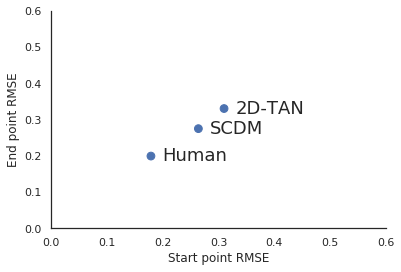

In [69]:
def rmse_comparison_charade():
    test_data = Charade2Instances(pd.read_csv('data/processed/test.csv'))
    result_2dtan = pkl.load(open("reports/figure_src/results/charade/2d-tan.pkl", "rb"))
    result_scdm = pkl.load(open("reports/figure_src/results/charade/scdm.pkl", "rb"))
    result_human = pkl.load(open("reports/outputs/performance/charade-sta/representative_human.pkl", "rb"))
    
    subresult_2dtan = []
    for item in result_2dtan:
        for key, _, _, _ in result_human:
            if key == item[0]:
                subresult_2dtan.append(item)
                break

    subresult_scdm = []
    for item in result_scdm:
        for key, _, _, _ in result_human:
            if key == item[0]:
                subresult_scdm.append(item)
                break
    
    rmse_error = []
    for res in [subresult_2dtan, subresult_scdm, result_human]:
        loc_errors = location_error(test_data, res)
        error = [x[1][:2] for x in loc_errors]
        error = np.asarray(error)
        error = error**2
        print("RMSE:", np.sqrt(np.mean(error, axis=0)))
        print(np.std(error, axis=0))
        rmse_error.append(np.sqrt(np.mean(error, axis=0)))
    return np.vstack(rmse_error)

rmse_error = rmse_comparison_charade()
plt.scatter(rmse_error[:, 0], rmse_error[:, 1], s=np.ones((len(rmse_error)))*60)
for loc, label in zip(rmse_error, ['2D-TAN', 'SCDM', 'Human']):
    plt.text(loc[0]+.02, loc[1], label, ha='left', va='center', fontsize=18)
plt.xlim(0, 0.6)
plt.ylim(0, 0.6)
plt.xlabel('Start point RMSE')
plt.ylabel('End point RMSE')
sns.despine()
plt.savefig('reports/figures/detailed_analysis/charade/RMSE/RMSE_charade.pdf', bbox_inches='tight')

Text(0.5, 1.0, 'SCDM')

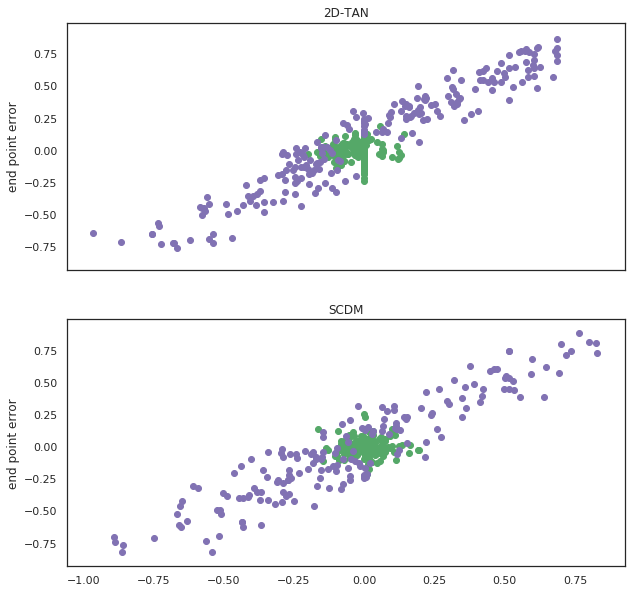

In [35]:
f, axes=plt.subplots(2,1,sharex=True,sharey=True, figsize=(10, 10))

for ax, res in zip(axes, [res_2dtan, res_scdm]):
    loc_errors = location_error(test_data, res)
    error = [x[1] for x in loc_errors if x[1][-1]]
    error = np.asarray(error)
    ax.scatter(error[:,0][::10], error[:,1][::10], color='g')
    error = [x[1] for x in loc_errors if not x[1][-1]]
    error = np.asarray(error)
    ax.scatter(error[:,0][::10], error[:,1][::10], color='m')
    # ax.set_xlabel('start point error')
    ax.set_ylabel('end point error')

axes[0].set_title('2D-TAN')
axes[1].set_title('SCDM')

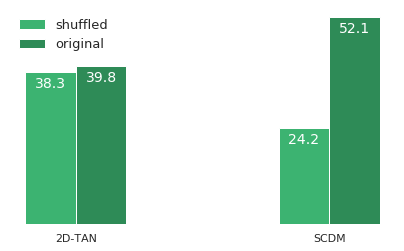

In [19]:
charade_scores = {
"2D-TAN": 39.81,
"2D-TAN\n(random)": 36.69,
"2D-TAN\n(shuffle)": 38.31,
"SCDM\n(shuffle)": 24.23,
"SCDM": 52.06, # https://arxiv.org/pdf/1910.14303.pdf
}

x_pos = np.asarray([0, 1])
step = .2
width = .2

sns.set_style("white")
plt.figure(figsize=(7, 4))
bars = plt.bar(x_pos,
        [charade_scores["2D-TAN\n(shuffle)"], charade_scores["SCDM\n(shuffle)"]],
        color="mediumseagreen",
        width=width,
        label="shuffled"
       )

for b in bars:
    plt.text(
        b.get_x()+width*.5,
        b.get_height()-4,
        f"{b.get_height():.1f}",
        horizontalalignment="center",
        color="w"
    )
    
bars = plt.bar(x_pos+step,
        [charade_scores["2D-TAN"], charade_scores["SCDM"]],
        color="seagreen",
        width=width,
        label="original"
       )

for b in bars:
    plt.text(
        b.get_x()+width*.5,
        b.get_height()-4,
        f"{b.get_height():.1f}",
        horizontalalignment="center",
        color="w"
    )
    
plt.xticks(x_pos+step*.5, ["2D-TAN", "SCDM"])
plt.legend(frameon=False, fontsize=13)
plt.gca().get_yaxis().set_visible(False)
sns.despine(left=True, bottom=True)
plt.savefig("reports/figures/performance_comparison/sanity_check_chrade.pdf", bbox_inches="tight")

In [112]:
predictions = pkl.load(open("/home/otani_mayu/3TDisk/Experiments/2D-TAN/results/random/Charades/TAN_vgg_rgb_test.pkl", "rb"))
preds = []
for p in predictions:
    query = (p[0][0], p[0][1]+".")
    seg = p[1]
    keep = _nms(np.asarray(seg), np.arange(len(seg))[::-1], thresh=0.5, top_k=5)
    seg = [seg[i] for i in keep]
    preds.append((query, seg, np.arange(len(seg))[::-1].tolist()))
results = evaluate(test_data, preds)
summary = accumulate_metrics(results)

R@1 IoU>0.3 0.49
R@1 IoU>0.5 0.37
R@1 IoU>0.7 0.19
R@5 IoU>0.3 0.88
R@5 IoU>0.5 0.76
R@5 IoU>0.7 0.47
R@10 IoU>0.3 0.88
R@10 IoU>0.5 0.76
R@10 IoU>0.7 0.47


In [111]:
predictions = pkl.load(open("/home/otani_mayu/3TDisk/Experiments/2D-TAN/results/shuffle/Charades/TAN_vgg_rgb_test.pkl", "rb"))
preds = []
for p in predictions:
    query = (p[0][0], p[0][1]+".")
    seg = p[1]
    keep = _nms(np.asarray(seg), np.arange(len(seg))[::-1], thresh=0.5, top_k=5)
    seg = [seg[i] for i in keep]
    preds.append((query, seg, np.arange(len(seg))[::-1].tolist()))
results = evaluate(test_data, preds)
summary = accumulate_metrics(results)
f"{summary['R@1 IoU>0.5'] * 100:.2f}"

R@1 IoU>0.3 0.53
R@1 IoU>0.5 0.38
R@1 IoU>0.7 0.20
R@5 IoU>0.3 0.91
R@5 IoU>0.5 0.77
R@5 IoU>0.7 0.47
R@10 IoU>0.3 0.91
R@10 IoU>0.5 0.77
R@10 IoU>0.7 0.47


'38.31'

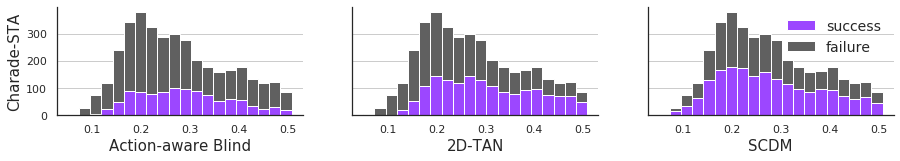

In [4]:
sns.set_style("white")
f, axes = plt.subplots(1, 3, sharey=True, sharex=True, figsize=(15, 2))

results = pkl.load(open("reports/figure_src/results/charade/blind(action).pkl", "rb"))
plot_performance_per_duration(results, test_data, axes[0])
xlim = axes[0].get_xlim()
axes[0].set_xlabel("Action-aware Blind", fontsize=15)
# axes[0].set_xticks([])
axes[0].get_legend().remove()
axes[0].yaxis.grid()
axes[0].set_ylabel("Charade-STA", fontsize=15)

results = pkl.load(open("reports/figure_src/results/charade/2d-tan.pkl", "rb"))
plot_performance_per_duration(results, test_data, axes[1])
axes[1].set_xlabel("2D-TAN", fontsize=15)
axes[1].set_xlim(xlim)
# axes[1].set_xticks([])
axes[1].get_legend().remove()
axes[1].yaxis.grid()

results = pkl.load(open("reports/figure_src/results/charade/scdm.pkl", "rb"))
plot_performance_per_duration(results, test_data, axes[2])
axes[2].set_xlabel("SCDM", fontsize=15)
axes[2].set_xlim(xlim)
axes[2].yaxis.grid()
# axes[2].get_legend().remove()

sns.despine()
plt.savefig("reports/figures/detailed_analysis/charade/performance_per_duration/blind-action_2d-tan_scdm.pdf", bbox_inches="tight")

# Comaprison on ActivityNet captions

In [65]:
raw_data = json.load(open("data/raw/ActivityNet/val_2.json"))
test_data = ActivityNetCap2Instances(raw_data)

In [114]:
predictions = pkl.load(open("/home/otani_mayu/3TDisk/Experiments/2D-TAN/results/shuffle/ActivityNet/TAN_c3d_test.pkl", "rb"))
preds = []
for p in predictions:
    query = p[0][0], p[0][1]
    seg = p[1]
    keep = _nms(np.asarray(seg), np.arange(len(seg))[::-1], thresh=0.5, top_k=5)
    seg = [seg[i] for i in keep]
    preds.append((query, seg, np.arange(len(seg))[::-1].tolist()))
results = evaluate(test_data, preds)
summary = accumulate_metrics(results)
f"{summary['R@1 IoU>0.5'] * 100:.2f}"

R@1 IoU>0.3 0.58
R@1 IoU>0.5 0.44
R@1 IoU>0.7 0.27
R@5 IoU>0.3 0.85
R@5 IoU>0.5 0.76
R@5 IoU>0.7 0.62
R@10 IoU>0.3 0.85
R@10 IoU>0.5 0.76
R@10 IoU>0.7 0.62


'43.68'

In [118]:
predictions = pkl.load(open("/home/otani_mayu/3TDisk/Experiments/2D-TAN/results/ActivityNet/TAN_c3d_test.pkl", "rb"))
preds = []
for p in predictions:
    query = p[0][0], p[0][1]
    seg = p[1]
    keep = _nms(np.asarray(seg), np.arange(len(seg))[::-1], thresh=0.5, top_k=5)
    seg = [seg[i] for i in keep]
    preds.append((query, seg, np.arange(len(seg))[::-1].tolist()))
results = evaluate(test_data, preds)
summary = accumulate_metrics(results)
f"{summary['R@1 IoU>0.5'] * 100:.2f}"

R@1 IoU>0.3 0.59
R@1 IoU>0.5 0.44
R@1 IoU>0.7 0.27
R@5 IoU>0.3 0.86
R@5 IoU>0.5 0.77
R@5 IoU>0.7 0.62
R@10 IoU>0.3 0.86
R@10 IoU>0.5 0.77
R@10 IoU>0.7 0.62


'44.05'

In [22]:
def get_random_sampling_from_uniform():
    metric = json.load(open('reports/outputs/performance/activitynet/random_from_uniform.json'))
    return np.mean(metric["R@1 IoU>0.5"])*100

print(f"Uniform: {get_random_sampling_from_uniform():.2f}")

Uniform: 13.57


R@1 IoU>0.3 0.58
R@1 IoU>0.5 0.41
R@1 IoU>0.7 0.24
R@5 IoU>0.3 0.85
R@5 IoU>0.5 0.76
R@5 IoU>0.7 0.63
R@10 IoU>0.3 0.85
R@10 IoU>0.5 0.76
R@10 IoU>0.7 0.63


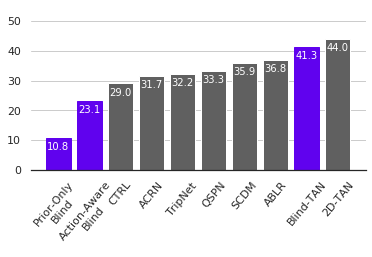

In [66]:
def get_activitynet_blindTAN_score():
    predictions = pkl.load(open("/home/otani_mayu/3TDisk/Experiments/2D-TAN/results/ActivityNet/BlindTAN_None_test.pkl", "rb"))
    preds = []
    for p in predictions:
        query = (p[0][0], p[0][1])
        seg = p[1]
        keep = _nms(np.asarray(seg), np.arange(len(seg))[::-1], thresh=0.5, top_k=5)
        seg = [seg[i] for i in keep]
        preds.append((query, seg, np.arange(len(seg))[::-1].tolist()))
    results = evaluate(test_data, preds)
    summary = accumulate_metrics(results)
    return summary

leaderboard = {}
leaderboard["Prior-Only\nBlind"] = 10.83
leaderboard["Action-Aware\nBlind"] = 23.14
leaderboard["Blind-TAN"] = get_activitynet_blindTAN_score()["R@1 IoU>0.5"] * 100

# leaderboard.update({
#     "CTRL'17": 29.01,
#     "ACRN'18": 31.67,
#     "QSPN'19": 33.26,
#     "ABLR'19": 36.79,
#     "TripNet'19": 32.19,
#     "2D-TAN'20": 44.05,
#     "SCDM'19": 35.86 # https://arxiv.org/pdf/1910.14303.pdf
# })

leaderboard.update({
    "CTRL": 29.01,
    "ACRN": 31.67,
    "QSPN": 33.26,
    "ABLR": 36.79,
    "TripNet": 32.19,
    "2D-TAN": 44.05,
    "SCDM": 35.86 # https://arxiv.org/pdf/1910.14303.pdf
})

labels = list(leaderboard.keys())
scores = list(leaderboard.values())
sorted_idx = np.argsort(scores)
scores = [scores[i] for i in sorted_idx]
labels = [labels[i] for i in sorted_idx]
n = len(sorted_idx)

sns.set_style("white")
plt.figure(figsize=(6, 3))
bars = plt.bar(np.arange(n), scores, color="#606060", width=0.8)
plt.xticks(np.arange(n), labels=labels, rotation=50)

bars[0].set_color("#6002ee")
bars[1].set_color("#6002ee")
bars[8].set_color("#6002ee")

def display_score(bar):
    plt.text(
        bar.get_x()+bar.get_width()*.5,
        bar.get_height()-4,
        f"{bar.get_height():.1f}",
        horizontalalignment="center",
        fontsize=10,
        color="w"
    )

for b in bars:
    display_score(b)

plt.gca().yaxis.grid()
plt.ylim(0.0, 54.663000000000004)
sns.despine(left=True)
plt.savefig("reports/figures/performance_comparison/performance_ActivityNetCap.pdf", bbox_inches="tight")

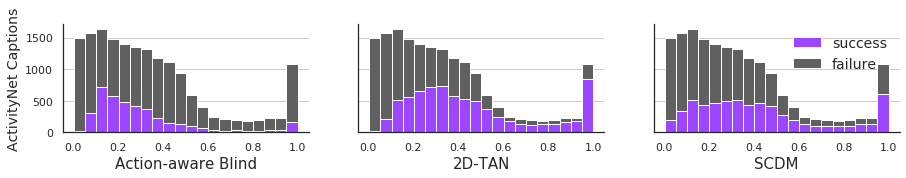

In [28]:
sns.set_style("white")
f, axes = plt.subplots(1, 3, sharey=True, sharex=True, figsize=(15, 2))
data_name = "activitynet"

results = pkl.load(open(f"reports/figure_src/results/{data_name}/blind(action).pkl", "rb"))
plot_performance_per_duration(results, test_data, axes[0])
xlim = axes[0].get_xlim()
axes[0].set_xlabel("Action-aware Blind", fontsize=15)
# axes[0].set_xticks([])
axes[0].get_legend().remove()
axes[0].yaxis.grid()
axes[0].set_ylabel("ActivityNet Captions", fontsize=14)

results = pkl.load(open(f"reports/figure_src/results/{data_name}/2d-tan.pkl", "rb"))
plot_performance_per_duration(results, test_data, axes[1])
axes[1].set_xlabel("2D-TAN", fontsize=15)
axes[1].set_xlim(xlim)
# axes[1].set_xticks([])
axes[1].get_legend().remove()
axes[1].yaxis.grid()

results = pkl.load(open(f"reports/figure_src/results/{data_name}/scdm.pkl", "rb"))
plot_performance_per_duration(results, test_data, axes[2])
axes[2].set_xlabel("SCDM", fontsize=15)
axes[2].set_xlim(xlim)
axes[2].yaxis.grid()

sns.despine()
plt.savefig(f"reports/figures/detailed_analysis/{data_name}/performance_per_duration/blind-action_2d-tan_scdm.pdf", bbox_inches="tight")

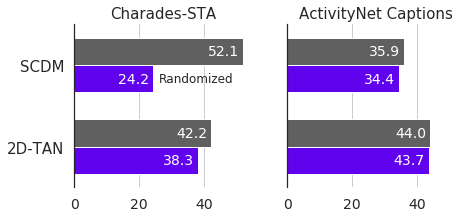

In [68]:
sns.set_style("white")
charade_scores = {
"2D-TAN": 42.2,
"2D-TAN\n(shuffle)": 38.31,
"SCDM\n(shuffle)": 24.23,
"SCDM": 52.06, # https://arxiv.org/pdf/1910.14303.pdf
}

activitynet_score = {
"2D-TAN": 44.05,
"2D-TAN\n(shuffle)": 43.68,
"SCDM\n(shuffle)": 34.36,
"SCDM": 35.86, # https://arxiv.org/pdf/1910.14303.pdf
}

color_a = "#606060"
color_b = "#6002ee"

f, axes = plt.subplots(1, 2, figsize=(7, 3), sharex=True, sharey=True)
pos = np.asarray([.2, .5])
height = 0.1
step = 0.1

done_put_label = False

for ax, score in zip(axes, [charade_scores, activitynet_score]):

    def display_score_h(bar):
        ax.text(
            bar.get_width()-6,
            bar.get_y()+bar.get_height()*.5,
            f"{bar.get_width():.1f}",
            horizontalalignment="center",
            verticalalignment="center",
            fontsize=14,
            color="w"
        )

    bars = ax.barh(pos+step,
                    [score["2D-TAN"],
                     score["SCDM"]],
                   height=height,
                   color=color_a
                   )

    for b in bars:
        display_score_h(b)

    bars = ax.barh(pos,
                    [score["2D-TAN\n(shuffle)"], 
                     score["SCDM\n(shuffle)"]],
                   height=height,
                   color=color_b
                   )


    for b in bars:
        display_score_h(b)

    if not done_put_label:
        ax.text(
            b.get_width()+2,
            b.get_y() + b.get_height()*.5,
            "Randomized",
            verticalalignment="center",
            fontsize=12
        )

        done_put_label = True

    ax.set_ylim([0.1, .7])

axes[0].set_title("Charades-STA", loc="center", fontsize=15)
axes[1].set_title("ActivityNet Captions", loc="center", fontsize=15)

axes[0].xaxis.grid()
axes[1].xaxis.grid()

axes[0].tick_params(labelsize=14)
axes[1].tick_params(labelsize=14)
plt.yticks(pos+height*.5, ["2D-TAN", "SCDM"])
plt.setp(axes[0].get_yticklabels(), fontsize = 15)

sns.despine(bottom=True)
plt.savefig("reports/figures/sanity_check/sanity_check.pdf", bbox_inches="tight")

RMSE: [0.27519773 0.38095101]
[0.14579653 0.2324466 ]
RMSE: [0.27048131 0.33614875]
[0.14412175 0.19497612]
RMSE: [0.23428233 0.34136738]
[0.133572   0.20920697]


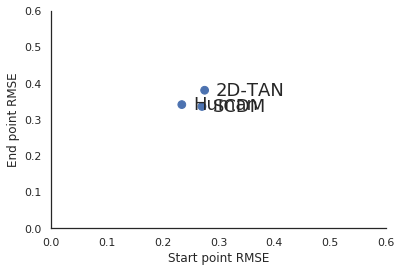

In [70]:
def rmse_comparison_activitynet():
    raw_data = json.load(open("data/raw/ActivityNet/val_2.json"))
    test_data = ActivityNetCap2Instances(raw_data)
    result_2dtan = pkl.load(open("reports/figure_src/results/activitynet/2d-tan.pkl", "rb"))
    result_scdm = pkl.load(open("reports/figure_src/results/activitynet/scdm.pkl", "rb"))
    result_human = pkl.load(open("reports/outputs/performance/activitynet/representative_human.pkl", "rb"))
    
    subresult_2dtan = []
    for item in result_2dtan:
        for key, _, _, _ in result_human:
            if key == item[0]:
                subresult_2dtan.append(item)
                break

    subresult_scdm = []
    for item in result_scdm:
        for key, _, _, _ in result_human:
            if key == item[0]:
                subresult_scdm.append(item)
                break
    
    rmse_error = []
    for res in [subresult_2dtan, subresult_scdm, result_human]:
        loc_errors = location_error(test_data, res)
        error = [x[1][:2] for x in loc_errors]
        error = np.asarray(error)
        error = error**2
        print("RMSE:", np.sqrt(np.mean(error, axis=0)))
        print(np.std(error, axis=0))
        rmse_error.append(np.sqrt(np.mean(error, axis=0)))
    return np.vstack(rmse_error)

rmse_error = rmse_comparison_activitynet()
plt.scatter(rmse_error[:, 0], rmse_error[:, 1], s=np.ones((len(rmse_error)))*60)
for loc, label in zip(rmse_error, ['2D-TAN', 'SCDM', 'Human']):
    plt.text(loc[0]+.02, loc[1], label, ha='left', va='center', fontsize=18)
plt.xlim(0, 0.6)
plt.ylim(0, 0.6)
plt.xlabel('Start point RMSE')
plt.ylabel('End point RMSE')
sns.despine()
plt.savefig('reports/figures/detailed_analysis/activitynet/RMSE/RMSE_activitynet.pdf', bbox_inches='tight')